##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Introduction to TensorFlow Part 3 - Advanced Tensor Manipulation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/aderdouri/ql_web_app/blob/master/tf_quant_finance_notebooks/Introduction_to_TensorFlow_Part_3_Advanced_Tensor_Manipulation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/aderdouri/ql_web_app/blob/master/tf_quant_finance_notebooks/Introduction_to_TensorFlow_Part_3_Advanced_Tensor_Manipulation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
#@title Upgrade to TensorFlow 2.5+
!pip install --upgrade tensorflow

In [ ]:
#@title Install and import Libraries for this colab. RUN ME FIRST!

import matplotlib.pyplot as plt
import tensorflow as tf



# What this notebook covers

This notebook carries on from [part 2](https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Introduction_to_TensorFlow_Part_2_-_Debugging_and_Control_Flow.ipynb
), and covers various advanced ways of manipulating tensors, including
*   Gather
*   Updating tensor entries
*   Sparse Tensors
*   Various functional ops:
    * tf.foldl 
    * tf.foldr
    * tf.map_fn
    * tf.vectorized_map

* XLA compilation





# Scatter / Gather

## tf.gather_nd

[Full documentation](https://www.tensorflow.org/api_docs/python/tf/gather_nd)

This operation allows you to take a multi-dimensional tensor and extract a list of subsets of data from it, according to a list of indices.

In [ ]:
source = tf.constant([[[111,112,113], [121,122,123], [131,132,133]], 
                      [[211,212,213], [221,222,223], [231,232,233]]])

# if we specify all values for all of source's dimensions, then we get a 
# single value
indices = [[1,1,1]]
print("Looking up %s gives us\n%s" %(
    indices, tf.gather_nd(source, indices)))

# we can look up multiple sets of indices
indices = [[1,1,1], [0,0,0], [0,0,1]]
print("\nLooking up %s gives us\n%s" %(
    indices, tf.gather_nd(source, indices)))

# if we don't specify values for all of source's dimensions, then we get 
# results of larger shape
indices = [[0,0]]
print("\nLooking up %s gives us\n%s" %(
    indices, tf.gather_nd(source, indices)))  
indices = [[1]]
print("\nLooking up %s gives us\n%s" %(
    indices, tf.gather_nd(source, indices)))    

Looking up [[1, 1, 1]] gives us
tf.Tensor([222], shape=(1,), dtype=int32)

Looking up [[1, 1, 1], [0, 0, 0], [0, 0, 1]] gives us
tf.Tensor([222 111 112], shape=(3,), dtype=int32)

Looking up [[0, 0]] gives us
tf.Tensor([[111 112 113]], shape=(1, 3), dtype=int32)

Looking up [[1]] gives us
tf.Tensor(
[[[211 212 213]
  [221 222 223]
  [231 232 233]]], shape=(1, 3, 3), dtype=int32)


The indices can easily be generated with tf.where:

In [ ]:
source = tf.constant([[[111,112,113], [121,122,123], [131,132,133]], 
                      [[211,212,213], [221,222,223], [231,232,233]]])
values_divisible_by_three = tf.gather_nd(
    source, tf.where(tf.equal(0, source % 3)))

print(values_divisible_by_three)

tf.Tensor([111 123 132 213 222 231], shape=(6,), dtype=int32)


## Updating elements of a Tensor

Tensors are immutable objects. Often there is a need to update certain values of a Tensor. In order to achieve this, one can use `tf.tensor_scatter_nd`, which creates a copy of the input Tensor along with updated values at the specified indices.

For user convenience a number of similar methods are available, such as `tf.tensor_scatter_nd_add/sub/min/max`.

In [ ]:
x = tf.constant([[[1, 2, 3], [4, 5, 6], [7, 8, 9]],
                [[11, 12, 13], [14, 15, 16], [17, 18, 19]]])
# Original Tensor
print("Original Tensor:\n%s"%x)

Original Tensor:
tf.Tensor(
[[[ 1  2  3]
  [ 4  5  6]
  [ 7  8  9]]

 [[11 12 13]
  [14 15 16]
  [17 18 19]]], shape=(2, 3, 3), dtype=int32)


In [ ]:
print("Updating a single single value:\n%s"%
      tf.tensor_scatter_nd_update(
          x,
          indices = [[0, 1, 2]],
          updates = [-1]))

print("\nUpdating multiple values:\n%s"%
      tf.tensor_scatter_nd_update(
          x,
          indices = [[0, 0, 0], [0, 1, 1], [0, 2, 2]], 
          updates = [-1, -2, -3]))

# You can reduce the dimensions of indices and increase the dimensions of 
# updates
print("\nScattering entire rows:\n%s"%
      tf.tensor_scatter_nd_update(
          x,
          indices = [[0,0], [0,1]], 
          updates = [[-1, -2, -3], [-4, -5,- 6]]))

print("\nUpdating the entire matrix:\n%s"%
      tf.tensor_scatter_nd_update(
          x,
          indices = [[0]], 
          updates = [[[-1, -2, -3], [-4, -5, -6], [-7, -8, -9]]]))

# Note that if `indices` contains duplicate or overlapping values, then the 
# clashing updates will be added together (in an indeterminate order, which 
# may result in non-deterministic output in the case of multiple floating 
# point values of wildly different sizes).
print("\nUpdating single value multiple times:\n%s"%
      tf.tensor_scatter_nd_update(
          x,
          indices = [[0,0,0], [0,0,0], [0,0,0]], 
          updates = [-1, -2, -3]))



Updating a single single value:
tf.Tensor(
[[[ 1  2  3]
  [ 4  5 -1]
  [ 7  8  9]]

 [[11 12 13]
  [14 15 16]
  [17 18 19]]], shape=(2, 3, 3), dtype=int32)

Updating multiple values:
tf.Tensor(
[[[-1  2  3]
  [ 4 -2  6]
  [ 7  8 -3]]

 [[11 12 13]
  [14 15 16]
  [17 18 19]]], shape=(2, 3, 3), dtype=int32)

Scattering entire rows:
tf.Tensor(
[[[-1 -2 -3]
  [-4 -5 -6]
  [ 7  8  9]]

 [[11 12 13]
  [14 15 16]
  [17 18 19]]], shape=(2, 3, 3), dtype=int32)

Updating the entire matrix:
tf.Tensor(
[[[-1 -2 -3]
  [-4 -5 -6]
  [-7 -8 -9]]

 [[11 12 13]
  [14 15 16]
  [17 18 19]]], shape=(2, 3, 3), dtype=int32)

Updating single value multiple times:
tf.Tensor(
[[[-3  2  3]
  [ 4  5  6]
  [ 7  8  9]]

 [[11 12 13]
  [14 15 16]
  [17 18 19]]], shape=(2, 3, 3), dtype=int32)


##tf.scatter_nd
[Full documentation](https://www.tensorflow.org/api_docs/python/tf/scatter_nd)

`scatter_nd` is similar to `tf.tensor_scatter_nd_update`. It creates a zero-initialised tensor of a given shape, and then writes a series of specified values at specified positions in that tensor.



### Gather then Update
In some cases, you will want `tensor_scatter_nd` to act as a "setter" to `gather_nd`'s "getter": i.e. you have a tensor, you extract a subset of values that meet a certain criteria using `gather_nd`, you calculate new values for that subset, and then create a new tensor based on the original that replaces the elements that met the criteria with the new values.


In [ ]:
source = tf.constant([[[111,112,113], [121,122,123], [131,132,133]], 
                      [[211,212,213], [221,222,223], [231,232,233]]])
# Create a list of indices where is_divisible_by_three is true (we no longer 
# need the to keep a reference to the result of tf.equal)
indices = tf.where(tf.equal(0, source % 3))
# Extract a list of values that need updating
values_divisible_by_three = tf.gather_nd(source, indices)
# Perform a really expensive operation on those values
new_values = values_divisible_by_three % 100
# Update entries in the original Tensor
new_tensor = tf.tensor_scatter_nd_update(
    source, indices, new_values)
# Updated Tensor
print(new_tensor)


tf.Tensor(
[[[ 11 112 113]
  [121 122  23]
  [131  32 133]]

 [[211 212  13]
  [221  22 223]
  [ 31 232 233]]], shape=(2, 3, 3), dtype=int32)


## Exercise: Mandlebrot set

Lets revisit the Mandlebrot set from the previous training course. In that solution, we ran the z=z*z+c calculation for all co-ordinates, even the ones whose magnitude had already gone over 2.

For the purpose of this exercise, we will pretend that the complex calculation is very expensive and that we should eliminate the calculation where possible. In actual fact, the calculation is utterly trivial and swamped by the cost of the gather/scatter operations, but the same methods can be used in situations rather more expensive than a complex add and multiply

In [ ]:
MAX_ITERATIONS = 64
NUM_PIXELS = 512

def generate_grid(nX, nY, bottom_left=(-1.0, -1.0), top_right=(1.0, 1.0)):
  """Generates a complex matrix of shape [nX, nY].
  
  Generates an evenly spaced grid of complex numbers spanning the rectangle 
  between the supplied diagonal points. 
  
  Args:
    nX: A positive integer. The number of points in the horizontal direction.
    nY: A positive integer. The number of points in the vertical direction.
    bottom_left: The coordinates of the bottom left corner of the rectangle to
      cover.
    top_right: The coordinates of the top right corner of the rectangle to
      cover.

  Returns:
    A constant tensor of type complex64 and shape [nX, nY].
  """
  x = tf.linspace(bottom_left[0], top_right[0], nX)
  y = tf.linspace(bottom_left[1], top_right[1], nY)
  real, imag = tf.meshgrid(x, y)
  return tf.cast(tf.complex(real, imag), tf.complex128)

c_values = generate_grid(NUM_PIXELS, NUM_PIXELS)
initial_Z_values = tf.zeros_like(c_values, dtype=tf.complex128)
initial_diverged_after = tf.ones_like(c_values, dtype=tf.int32) * MAX_ITERATIONS

# You need to put the various values you want to change inside the loop here
loop_vars = (0, initial_Z_values, initial_diverged_after)

# this needs to take the same number of arguments as loop_vars contains and
# return a tuple of equal size with the next iteration's values
def body(iteration_count, Z_values, diverged_after):
  # a matrix of bools showing all the co-ordinatesthat haven't diverged yet
  not_diverged = tf.equal(diverged_after, MAX_ITERATIONS)
  # a list of the indices in not_diverged that are true
  not_diverged_indices = tf.where(not_diverged)

  # you now need to gather just the Z and c values covered by 
  # not_diverged_indices, calculate the new Z values, and then scatter the 
  # values back into a new Z_values matrix to pass to the next iteration.

  new_Z_values = # TODO

  # And now we're back to the original code
  has_diverged = tf.abs(new_Z_values) > 2.0
  new_diverged_after = tf.minimum(diverged_after, tf.where(
      has_diverged, iteration_count, MAX_ITERATIONS))

  return (iteration_count+1, new_Z_values, new_diverged_after)

# this just needs to take the same number of arguments as loop_vars contains and
# return true (we'll use maximum_iterations to exit the loop)
def cond(iteration_count, Z_values, diverged_after):
  return True

results = tf.while_loop(
    loop_vars=loop_vars, 
    body = body, 
    cond = cond, 
    maximum_iterations=MAX_ITERATIONS)


## extract the final value of diverged_after from the tuple
final_diverged_after = results[-1]
plt.matshow(final_diverged_after)
pass

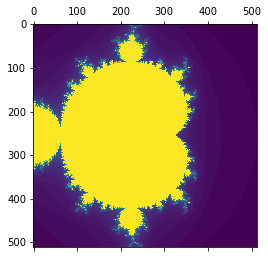

In [ ]:
#@title Solution: Mandlebrot set (Double-click to reveal)

MAX_ITERATIONS = 64
NUM_PIXELS = 512

def GenerateGrid(nX, nY, bottom_left=(-1.0, -1.0), top_right=(1.0, 1.0)):
  """Generates a complex matrix of shape [nX, nY].
  
  Generates an evenly spaced grid of complex numbers spanning the rectangle 
  between the supplied diagonal points. 
  
  Args:
    nX: A positive integer. The number of points in the horizontal direction.
    nY: A positive integer. The number of points in the vertical direction.
    bottom_left: The coordinates of the bottom left corner of the rectangle to
      cover.
    top_right: The coordinates of the top right corner of the rectangle to
      cover.

  Returns:
    A constant tensor of type complex64 and shape [nX, nY].
  """
  x = tf.linspace(bottom_left[0], top_right[0], nX)
  y = tf.linspace(bottom_left[1], top_right[1], nY)
  real, imag = tf.meshgrid(x, y)
  return tf.cast(tf.complex(real, imag), tf.complex128)

c_values = GenerateGrid(NUM_PIXELS, NUM_PIXELS)
initial_Z_values = tf.zeros_like(c_values, dtype=tf.complex128)
initial_diverged_after = tf.ones_like(c_values, dtype=tf.int32) * MAX_ITERATIONS

# You need to put the various values you want to change inside the loop here
loop_vars = (0, initial_Z_values, initial_diverged_after)

# this needs to take the same number of arguments as loop_vars contains and
# return a tuple of equal size with the next iteration's values
def body(iteration_count, Z_values, diverged_after):
  # a matrix of bools showing all the co-ordinatesthat haven't diverged yet
  not_diverged = tf.equal(diverged_after, MAX_ITERATIONS)
  # a list of the indices in not_diverged that are true
  not_diverged_indices = tf.where(not_diverged)

  # Gather the values for just the undiverged co-ordinates, and generate the 
  # next iteration's values
  not_diverged_c_values_array = tf.gather_nd(c_values, not_diverged_indices)
  not_diverged_Z_values_array = tf.gather_nd(Z_values, not_diverged_indices)
  new_Z_values_array = (not_diverged_Z_values_array * not_diverged_Z_values_array
                        + not_diverged_c_values_array)
  
  # merge the new values with the already-diverged
  new_Z_values_or_zeroes = tf.scatter_nd(
      not_diverged_indices, 
      new_Z_values_array, 
      tf.shape(Z_values, out_type=tf.dtypes.int64))
  new_Z_values = tf.where(not_diverged, new_Z_values_or_zeroes, Z_values)

  # And now we're back to the original code
  has_diverged = tf.abs(new_Z_values) > 2.0
  new_diverged_after = tf.minimum(diverged_after, tf.where(
      has_diverged, iteration_count, MAX_ITERATIONS))
  return (iteration_count+1, new_Z_values, new_diverged_after)

# this just needs to take the same number of arguments as loop_vars contains and
# return true (we'll use maximum_iterations to exit the loop)
def cond(iteration_count, Z_values, diverged_after):
  return True

results = tf.while_loop(
    loop_vars=loop_vars, 
    body = body, 
    cond = cond, 
    maximum_iterations=MAX_ITERATIONS)

## extract the final value of diverged_after from the tuple
final_diverged_after = results[-1]
plt.matshow(final_diverged_after)
plt.show()

## SparseTensor

[Full documentation](https://www.tensorflow.org/api_docs/python/tf/sparse/SparseTensor])

A sparse tensor is created from a list of indices, a list of values and a shape: the same as the arguments to scatter_nd. Any element within the tensor that doesn't have an explicit value will be treated as zero. So a sparse tensor can be viewed as a deferred call to scatter_nd.

For large tensors where most of the values are zero, sparse tensors can grant major savings in memory. The [tf.sparse module](https://www.tensorflow.org/api_docs/python/tf/sparse) contains several specialised operations that know how to work with sparse tensor's internals and skipping all the zero values, thus granting major savings in processing speed as well.

Similarly sparse tensors can be efficiently divided or multiplied by a tensor or scalar. But attempts to perform inefficient operations on a sparse tensor (i.e. ones likely to set most elements to a non-zero value) are not allowed. You need to convert the sparse tensor to a normal, or "dense", tensor with the ```tf.sparse.to_dense``` function.

In [ ]:
source = tf.constant([[[111,112,113], [121,122,123], [131,132,133]], 
                      [[211,212,213], [221,222,223], [231,232,233]]])
# create a list of indices where is_divisible_by_three is true
indices = tf.where(tf.equal(0, source % 3))
# extract a matching list of values
values_divisible_by_three = tf.gather_nd(source, indices)

sparse = tf.sparse.SparseTensor(
    indices, 
    values_divisible_by_three, 
    tf.shape(source, out_type=tf.dtypes.int64))
print ("sparse =")
print(sparse)
# We can efficiently multiply sparse by a dense tensor
print ("\nsparse * dense =")
print(sparse * source)
# We can efficiently multiply a dense tensor by a sparse
print ("\ndense * sparse")
print(source * sparse)
# We can efficiently divide sparse by a dense tensor
print ("\nsparse / dense")
print(sparse / source)

# But attempts to perform inefficient operations on a sparse tensor (i.e. ones
# likely to set most elements to a non-zero value) are not allowed.
# You need to convert the sparse tensor into a dense tensor first.
try:
  not_allowed = sparse + source
except ValueError:
  pass

# Running to_dense is exactly the same as calling scatter_nd:
print ("\nto_dense gives")
print(tf.sparse.to_dense(sparse))
print ("\nscatter_nd gives")
print(tf.scatter_nd(sparse.indices, sparse.values, sparse.dense_shape))

sparse =
SparseTensor(indices=tf.Tensor(
[[0 0 0]
 [0 1 2]
 [0 2 1]
 [1 0 2]
 [1 1 1]
 [1 2 0]], shape=(6, 3), dtype=int64), values=tf.Tensor([111 123 132 213 222 231], shape=(6,), dtype=int32), dense_shape=tf.Tensor([2 3 3], shape=(3,), dtype=int64))

sparse * dense =
SparseTensor(indices=tf.Tensor(
[[0 0 0]
 [0 1 2]
 [0 2 1]
 [1 0 2]
 [1 1 1]
 [1 2 0]], shape=(6, 3), dtype=int64), values=tf.Tensor([12321 15129 17424 45369 49284 53361], shape=(6,), dtype=int32), dense_shape=tf.Tensor([2 3 3], shape=(3,), dtype=int64))

dense * sparse
SparseTensor(indices=tf.Tensor(
[[0 0 0]
 [0 1 2]
 [0 2 1]
 [1 0 2]
 [1 1 1]
 [1 2 0]], shape=(6, 3), dtype=int64), values=tf.Tensor([12321 15129 17424 45369 49284 53361], shape=(6,), dtype=int32), dense_shape=tf.Tensor([2 3 3], shape=(3,), dtype=int64))

sparse / dense
SparseTensor(indices=tf.Tensor(
[[0 0 0]
 [0 1 2]
 [0 2 1]
 [1 0 2]
 [1 1 1]
 [1 2 0]], shape=(6, 3), dtype=int64), values=tf.Tensor([1. 1. 1. 1. 1. 1.], shape=(6,), dtype=float64), dense_

# Functional ops

## tf.foldl and tf.foldr

[Full documentation](https://www.tensorflow.org/api_docs/python/tf/foldl)

These two functions split a given tensor across its first dimension. The resulting subtensors are then each passed to an op along with an "accumulator". 
For most iterations, the value of the accumulator will be the result of the previous iteration. But for the first iteration, the accumulator will either be passed an initial value passed into the foldl/foldr call, or the first subtensor. The final iteration's result then becomes the overall result of the op.

So the rough pseudo code of ```x = tf.foldl(op, [[1,1], [2,2], [3,3]], initializer)``` would be
``` python
result_iteration1 = op(initializer, [1,1])
result_iteration2 = op(result_iteration1, [2,2])
result iteration3 = op(result_iteration2, [3,3])
x = result_iteration3
```
Whereas the rough pseudo-code of  ```x = tf.foldl(op, [[1,1], [2,2], [3,3])``` (i.e. no initializer supplied) would be
``` python
result_iteration1 = op([1,1]], [2,2])
result_iteration2 = op(result_iteration1, [3,3])
x = result_iteration3
```

```foldr``` is identical to ```foldl```, except that the order the tensor is iterated through is reversed. So the rough pseudo code of ```x = tf.foldr(op, [[1,1], [2,2], [3,3], initializer)``` would be
``` python
result_iteration1 = op(initializer, [3,3])
result_iteration2 = op(result_iteration1, [2,2])
result iteration3 = op(result_iteration2, [1,1])
x = result_iteration3
```

The only complication of this method is that the op is defined by a python callable. Note that the callable is only called once, at execution time, to build the operation. **Your python callable is not called for every row in the input**, nor can it see the individual values. It is the op created by your python code that will be repeatedly called. 

Note that despite this, use of these methods still eliminates several optimisation opportunities that are present in tensorflow built-in operations. So if you can use something like `tf.math.reduce_sum` instead of these ops then your code may well run significantly faster.

In [ ]:
source = tf.constant([[1,2],[3,4],[5,6]])

# element
@tf.function
def my_function(previous_iterations_result, element):
  print("In my_function.")
  # this depends on the previous values, thus highlighting the difference 
  # between foldl and foldr
  return tf.math.maximum(
      previous_iterations_result, element) + previous_iterations_result

print("Executing foldl")
print("foldl result:\n%s"%
      tf.foldl(my_function, source))

print("\nExecuting foldr")
print("foldr result:\n%s"%
      tf.foldr(my_function, source))


Executing foldl
In my_function.
foldl result:
tf.Tensor([ 9 12], shape=(2,), dtype=int32)

Executing foldr
foldr result:
tf.Tensor([20 24], shape=(2,), dtype=int32)


## tf.map_fn

This op is similar to `foldl`, but the python function only takes a single argument, it lacks the accumulator argument containing the result of the previous iteration. Again the callable is called just once, and is used to generate an tensorflow op. It is this generated op that is executed once per row. And again, be aware that replacing the map_fn call with a built-in op - if possible - can result in significant increases in speed.

In [ ]:
source = tf.constant([[1,2],[3,4],[5,6]])

# element 
@tf.function
def my_function(element):
  print("In my_function")  
  return tf.math.reduce_sum(element)


print("foldr result:\n%s"%
      tf.map_fn(my_function, source))

In my_function
foldr result:
tf.Tensor([ 3  7 11], shape=(3,), dtype=int32)


## tf.vectrorized_map

This op is similar to `map_fn`, but has a much better performance due to vectorization. `map_fn` is serial since it is based on `tf.while_loop`, while `tf.vectorized_map` relies on [`pfor`](https://github.com/tensorflow/tensorflow/blob/a4dfb8d1a71385bd6d122e4f27f86dcebb96712d/tensorflow/python/ops/parallel_for/control_flow_ops.py#L546) (parallel for) in its implementation. Potential speed can be the same as from batching.

The op is useful to parallelize tasks where batching is hard to achieve (e.g., Jacobian calculation).

See [official documentation](https://www.tensorflow.org/api_docs/python/tf/vectorized_map) for more details.

Again the callable is called just once, and is used to generate a tensorflow op.

In [ ]:
source = tf.constant([[1,2],[3,4],[5,6]])

# element 
@tf.function
def my_function(element):
  print("In my_function")
  return tf.math.reduce_sum(element)


print("foldr result:\n%s"%
      tf.vectorized_map(my_function, source))

In my_function
foldr result:
tf.Tensor([ 3  7 11], shape=(3,), dtype=int32)


In [ ]:
# Vectorization map vs map_fn vs batching

@tf.function
def square_map(x):
  return tf.map_fn(lambda x: x**2, x)

@tf.function
def square_vectorized_map(x):
  return tf.vectorized_map(lambda x: x**2, x)

In [ ]:
dtype = tf.float64
x = tf.random.uniform([1_000], dtype=dtype)

When timing, we call `.numpy()` to ensure the result is copied to memory.

In [ ]:
%%timeit
# map_fn speed
square_map(x).numpy()

100 loops, best of 5: 9.01 ms per loop


In [ ]:
%%timeit
# vectorized_map speed
square_vectorized_map(x).numpy()

1000 loops, best of 5: 173 µs per loop


In [ ]:
%%timeit
# Batched version
(x**2).numpy()

10000 loops, best of 5: 123 µs per loop


# XLA compilation

One of the main TensorFlow concepts is computational graph. One can imagine that knowing the graph should provide enough information to create an efficient low-level code targeting a specific device (i.e., CPU/GPU/TPU). XLA (Accelerated Linear Algebra) is a compiler that does precisely that - it creates an LLVM representation from the computational graph, potentially brinning significant speed up to the calculation. Compilation can be done in either Ahead-of-time (AOT) or Just-in-time (JIT) modes.

Refer to the [official XLA page](https://www.tensorflow.org/xla) for more details. XLA Architecture details can be found [here](https://www.tensorflow.org/xla/architecture).

From user perspective, using JIT compilation is easy: simply set `jit_compile=True` argument of `tf.function`. 

To use AOT compilation mode please refer to the [documentation](https://www.tensorflow.org/xla/tfcompile).


**NB**  
  * At the moment not every function can be XLA-compiled. For example, inputs and output shapes of `tf.while_loop` should be the same. Also, some of the ops might be missing an XLA implementation.
  * JIT-compilation means that compilation happens at the first function call. For the successive calls, the compiled function is used. If an input has a different shape from the one used during the compilation, JIT-compilation happens again for the new input shapes.


In [ ]:
@tf.function
def square_map(x):
  return tf.map_fn(lambda x: x**2, x)

@tf.function(jit_compile=True)
def square_map_xla(x):
  return tf.map_fn(lambda x: x**2, x)

@tf.function(jit_compile=True)
def square_vectorized_map_xla(x):
  return tf.vectorized_map(lambda x: x**2, x)

In [ ]:
dtype = tf.float64
x = tf.random.uniform([1_000], dtype=dtype)

In [ ]:
%%timeit
square_map(x).numpy()

100 loops, best of 5: 9 ms per loop


In [ ]:
%%timeit
# Compare time to the non-compiled code above
square_map_xla(x).numpy()

1000 loops, best of 5: 228 µs per loop


In [ ]:
# Now compare with compiled vectorized_map
x = tf.random.uniform([500_000], dtype=dtype)

In [ ]:
%%timeit
# map_fn + XLA
square_map_xla(x).numpy()

100 loops, best of 5: 2.67 ms per loop


In [ ]:
%%timeit
# vectorized_map + XLA
square_vectorized_map(x).numpy()

1000 loops, best of 5: 999 µs per loop
